In [58]:
# Install pytorch and tqdm (if necessary)
!pip install torch
!pip install torchvision
!pip install tqdm

In [59]:
# Mount your google drive as the data drive
# This will require google authorization
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
# Handle imports

import math
import os
import datetime
import csv
%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import numpy as np
import tqdm

from IPython import display

In [0]:
# The Args object will contain all of our parameters
# If you want to run with different arguments, create another Args object

class Args(object):
  def __init__(self, name='mnist', batch_size=64, test_batch_size=1000,
            epochs=10, lr=0.01, optimizer='sgd', momentum=0.5,
            seed=1, log_interval=100, dataset='mnist',
            data_dir='/content/drive/My Drive/cs482/data', model='default',
            cuda=True):
    self.name = name # name for this training run. Don't use spaces.
    self.batch_size = batch_size
    self.test_batch_size = test_batch_size # Input batch size for testing
    self.epochs = epochs # Number of epochs to train
    self.lr = lr # Learning rate
    self.optimizer = optimizer # sgd/p1sgd/adam/rms_prop
    self.momentum = momentum # SGD Momentum
    self.seed = seed # Random seed
    self.log_interval = log_interval # Batches to wait before logging
                                     # detailed status. 0 = never
    self.dataset = dataset # mnist/fashion_mnist
    self.data_dir = data_dir
    self.model = model # default/P2Q7DoubleChannelsNet/P2Q7HalfChannelsNet/
                  # P2Q8BatchNormNet/P2Q9DropoutNet/P2Q10DropoutBatchnormNet/
                  # P2Q11ExtraConvNet/P2Q12RemoveLayerNet/P2Q13UltimateNet
    self.cuda = cuda and torch.cuda.is_available()

In [0]:
# The Args object will contain all of our parameters
# If you want to run with different arguments, create another Args object
P1m = Args(name='mnist', batch_size=64, test_batch_size=1000,
            epochs=10, lr=0.01, optimizer='sgd', momentum=0.5,
            seed=1, log_interval=100, dataset='mnist',
            data_dir='/content/drive/My Drive/cs482/data', model='default',
            cuda=True)
P1f = Args(name='fashion_mnist_parallel', batch_size=64, test_batch_size=1000,
            epochs=10, lr=0.01, optimizer='sgd', momentum=0.5,
            seed=1, log_interval=100, dataset='fashion_mnist',
            data_dir='/content/drive/My Drive/cs482/data', model='default',
            cuda=True)
P2m = Args(name='mnist', batch_size=64, test_batch_size=1000,
            epochs=20, lr=0.01, optimizer='sgd', momentum=0.5,
            seed=1, log_interval=100, dataset='mnist',
            data_dir='/content/drive/My Drive/cs482/data', model='default',
            cuda=True)
P2f = Args(name='fashion_mnist_parallel', batch_size=64, test_batch_size=1000,
            epochs=20, lr=0.01, optimizer='sgd', momentum=0.5,
            seed=1, log_interval=100, dataset='fashion_mnist',
            data_dir='/content/drive/My Drive/cs482/data', model='default',
            cuda=True)
P3a = Args(name='fashion_mnist_parallel', batch_size=64, test_batch_size=1000,
            epochs=10, lr=0.01/10, optimizer='sgd', momentum=0.5,
            seed=1, log_interval=100, dataset='fashion_mnist',
            data_dir='/content/drive/My Drive/cs482/data', model='default',
            cuda=True)
P3b = Args(name='fashion_mnist_parallel', batch_size=64, test_batch_size=1000,
            epochs=10, lr=0.01*10, optimizer='sgd', momentum=0.5,
            seed=1, log_interval=100, dataset='fashion_mnist',
            data_dir='/content/drive/My Drive/cs482/data', model='default',
            cuda=True)
P4a = Args(name='fashion_mnist_parallel', batch_size=64, test_batch_size=1000,
            epochs=10, lr=0.01, optimizer='adam', momentum=0.5,
            seed=1, log_interval=100, dataset='fashion_mnist',
            data_dir='/content/drive/My Drive/cs482/data', model='default',
            cuda=True)
P4b = Args(name='fashion_mnist_parallel', batch_size=64, test_batch_size=1000,
            epochs=10, lr=0.01, optimizer='rms_prop', momentum=0.5,
            seed=1, log_interval=100, dataset='fashion_mnist',
            data_dir='/content/drive/My Drive/cs482/data', model='default',
            cuda=True)
P6a = Args(name='fashion_mnist_parallel', batch_size=64/8, test_batch_size=1000,
            epochs=10, lr=0.01, optimizer='sgd', momentum=0.5,
            seed=1, log_interval=100, dataset='fashion_mnist',
            data_dir='/content/drive/My Drive/cs482/data', model='default',
            cuda=True)
P6b = Args(name='fashion_mnist_parallel', batch_size=64*8, test_batch_size=1000,
            epochs=10, lr=0.01, optimizer='sgd', momentum=0.5,
            seed=1, log_interval=100, dataset='fashion_mnist',
            data_dir='/content/drive/My Drive/cs482/data', model='default',
            cuda=True)
P7a = Args(name='fashion_mnist_parallel', batch_size=64, test_batch_size=1000,
            epochs=10, lr=0.01, optimizer='sgd', momentum=0.5,
            seed=1, log_interval=100, dataset='fashion_mnist',
            data_dir='/content/drive/My Drive/cs482/data', model='P2Q7HalfChannelsNet',
            cuda=True)
P7b = Args(name='fashion_mnist_parallel', batch_size=64, test_batch_size=1000,
            epochs=10, lr=0.01, optimizer='sgd', momentum=0.5,
            seed=1, log_interval=100, dataset='fashion_mnist',
            data_dir='/content/drive/My Drive/cs482/data', model='P2Q7DoubleChannelsNet',
            cuda=True)
P8 = Args(name='fashion_mnist_parallel', batch_size=64, test_batch_size=1000,
            epochs=10, lr=0.01, optimizer='sgd', momentum=0.5,
            seed=1, log_interval=100, dataset='fashion_mnist',
            data_dir='/content/drive/My Drive/cs482/data', model='P2Q8BatchNormNet',
            cuda=True)
P9 = Args(name='fashion_mnist_parallel', batch_size=64, test_batch_size=1000,
            epochs=10, lr=0.01, optimizer='sgd', momentum=0.5,
            seed=1, log_interval=100, dataset='fashion_mnist',
            data_dir='/content/drive/My Drive/cs482/data', model='P2Q9DropoutNet',
            cuda=True)
P10 = Args(name='fashion_mnist_parallel', batch_size=64, test_batch_size=1000,
            epochs=10, lr=0.01, optimizer='sgd', momentum=0.5,
            seed=1, log_interval=100, dataset='fashion_mnist',
            data_dir='/content/drive/My Drive/cs482/data', model='P2Q10DropoutBatchnormNet',
            cuda=True)
P11 = Args(name='fashion_mnist_parallel', batch_size=64, test_batch_size=1000,
            epochs=10, lr=0.01, optimizer='sgd', momentum=0.5,
            seed=1, log_interval=100, dataset='fashion_mnist',
            data_dir='/content/drive/My Drive/cs482/data', model='P2Q11ExtraConvNet',
            cuda=True)
P12 = Args(name='fashion_mnist_parallel', batch_size=64, test_batch_size=1000,
            epochs=10, lr=0.01, optimizer='sgd', momentum=0.5,
            seed=1, log_interval=100, dataset='fashion_mnist',
            data_dir='/content/drive/My Drive/cs482/data', model='P2Q12RemoveLayerNet',
            cuda=True)
P13 = Args(name='fashion_mnist_parallel', batch_size=64, test_batch_size=1000,
            epochs=30, lr=0.01, optimizer='sgd', momentum=0.5,
            seed=1, log_interval=100, dataset='fashion_mnist',
            data_dir='/content/drive/My Drive/cs482/data', model='P2Q13UltimateNet',
            cuda=True)
P14 = Args(name='mnist', batch_size=64, test_batch_size=1000,
            epochs=30, lr=0.01, optimizer='sgd', momentum=0.5,
            seed=1, log_interval=100, dataset='mnist',
            data_dir='/content/drive/My Drive/cs482/data', model='P2Q13UltimateNet',
            cuda=True)
P15 = Args(name='mnist', batch_size=64, test_batch_size=1000,
            epochs=30, lr=0.01/20, optimizer='sgd', momentum=0.5,
            seed=1, log_interval=100, dataset='mnist',
            data_dir='/content/drive/My Drive/cs482/data', model='P2Q13UltimateNet',
            cuda=True)

In [0]:
# Define the neural network classes

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        # F is just a functional wrapper for modules from the nn package
        # see http://pytorch.org/docs/_modules/torch/nn/functional.html
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


class P2Q7HalfChannelsNet(nn.Module):
    def __init__(self):
        super(P2Q7HalfChannelsNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 5, kernel_size=5)
        self.conv2 = nn.Conv2d(5, 10, kernel_size=5)
        self.fc1 = nn.Linear(160, 25)
        self.fc2 = nn.Linear(25, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 160)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


class P2Q7DoubleChannelsNet(nn.Module):
    def __init__(self):
        super(P2Q7DoubleChannelsNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=5)
        self.conv2 = nn.Conv2d(20, 40, kernel_size=5)
        self.fc1 = nn.Linear(640, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 640)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

class P2Q8BatchNormNet(nn.Module):
    def __init__(self):
        super(P2Q8BatchNormNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv1_bn = nn.BatchNorm2d(10)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = self.conv1_bn(x)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

class P2Q9DropoutNet(nn.Module):
    def __init__(self):
        super(P2Q9DropoutNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv1_bn = nn.BatchNorm2d(10)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = self.conv1_bn(x)
        x = F.dropout(x, training=self.training)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

class P2Q10DropoutBatchnormNet(nn.Module):
    def __init__(self):
        super(P2Q10DropoutBatchnormNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv1_bn = nn.BatchNorm2d(10)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.dropout(x, training=self.training)
        x = self.conv1_bn(x)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

class P2Q11ExtraConvNet(nn.Module):
    def __init__(self):
        super(P2Q11ExtraConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv3 = nn.Conv2d(20, 80, kernel_size=2)
        self.fc1 = nn.Linear(80, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = x.view(-1, 80)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

class P2Q12RemoveLayerNet(nn.Module):
    def __init__(self):
        super(P2Q12RemoveLayerNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.fc1 = nn.Linear(1440, 50)
        self.fc2 = nn.Linear(50, 10)
      
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = x.view(-1, 1440)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
      

class P2Q13UltimateNet(nn.Module):
    def __init__(self):
        super(P2Q13UltimateNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 80, kernel_size=5)
        self.fc1 = nn.Linear(12*12*80, 12*80)
        self.fc2 = nn.Linear(12*80, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.dropout(x, 0.5, training=self.training)
        x = x.view(-1, 12*12*80)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


In [0]:
def prepare_dataset(args):
    # choose the dataset
    if args.dataset == 'mnist':
        DatasetClass = datasets.MNIST
    elif args.dataset == 'fashion_mnist':
        DatasetClass = datasets.FashionMNIST
    else:
        raise ValueError('unknown dataset: ' + args.dataset +
                ' try mnist or fashion_mnist')

    def time_stamp(fname, fmt='%m-%d-%H-%M_{fname}'):
        return datetime.datetime.now().strftime(fmt).format(fname=fname)
        
    training_run_name = time_stamp(args.dataset + '_' + args.name)

    kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}

    # Create the dataset: mnist or fasion_mnist
    dataset_dir = os.path.join(args.data_dir, args.dataset)
    training_run_dir = os.path.join(args.data_dir, training_run_name)
    train_dataset = DatasetClass(
        dataset_dir, train=True, download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ]))
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=args.batch_size, shuffle=True, **kwargs)
    test_dataset = DatasetClass(
        dataset_dir, train=False, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ]))
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=args.test_batch_size, shuffle=True, **kwargs)
    
    if not os.path.exists(training_run_dir):
        os.makedirs(training_run_dir)

    return train_loader, test_loader, train_dataset, test_dataset, training_run_dir

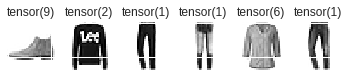

In [75]:
# visualize some images

args = P13
_, _, _, test_dataset, _ = prepare_dataset(args)
images = test_dataset.test_data[:6]
labels = test_dataset.test_labels[:6]
fig, axes = plt.subplots(1,6)
for axis, img, lbl in zip(axes, images, labels):
    axis.imshow(img)
    axis.set_title(lbl)
    axis.set_yticklabels([])
    axis.set_xticklabels([])
plt.show()


In [0]:
def train(model, optimizer, train_loader, epoch, total_minibatch_count,
        train_losses, train_accs):
    # Training for a full epoch

    model.train()
    correct_count, total_loss, total_acc = 0., 0., 0.
    progress_bar = tqdm.tqdm(train_loader, desc='Training')
    
    for batch_idx, (data, target) in enumerate(progress_bar):
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)

        optimizer.zero_grad()

        # Forward prediction step
        output = model(data)
        loss = F.nll_loss(output, target)

        # Backpropagation step
        loss.backward()
        optimizer.step()

        # The batch has ended, determine the accuracy of the predicted outputs
        pred = output.data.max(1)[1]  

        # target labels and predictions are categorical values from 0 to 9.
        matches = target == pred
        accuracy = matches.float().mean()
        correct_count += matches.sum()

        if args.log_interval != 0 and \
                total_minibatch_count % args.log_interval == 0:

            train_losses.append(loss.data[0])
            train_accs.append(accuracy.data[0])
            
        total_loss += loss.data
        total_acc += accuracy.data
            
        progress_bar.set_description(
            'Epoch: {} loss: {:.4f}, acc: {:.2f}'.format(
                epoch, total_loss / (batch_idx + 1), total_acc / (batch_idx + 1)))
        #progress_bar.refresh()

        total_minibatch_count += 1

    return total_minibatch_count

In [0]:
def test(model, test_loader, epoch, total_minibatch_count,
        val_losses, val_accs):
    # Validation Testing
    model.eval()
    test_loss, correct = 0., 0.
    progress_bar = tqdm.tqdm(test_loader, desc='Validation')
    with torch.no_grad():
        for data, target in progress_bar:
            if args.cuda:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data), Variable(target)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').data  # sum up batch loss
            pred = output.data.max(1)[1]  # get the index of the max log-probability
            correct += (target == pred).float().sum()

    test_loss /= len(test_loader.dataset)
    
    acc = correct / len(test_loader.dataset)

    val_losses.append(test_loss)
    val_accs.append(acc)
    
    progress_bar.clear()
    progress_bar.write(
        '\nEpoch: {} validation test results - Average val_loss: {:.4f}, val_acc: {}/{} ({:.2f}%)'.format(
            epoch, test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

    return acc

In [0]:
# Run the experiment
def run_experiment(args):

    total_minibatch_count = 0

    torch.manual_seed(args.seed)
    if args.cuda:
        torch.cuda.manual_seed(args.seed)

    train_loader, test_loader, _, _, run_path = prepare_dataset(args)

    epochs_to_run = args.epochs

    # Choose model
    # TODO add all the other models here if their parameter is specified
    if args.model == 'default' or args.model == 'P2Q7DefaultChannelsNet':
        model = Net()
    elif args.model in globals():
        model = globals()[args.model]()
    else:
        raise ValueError('Unknown model type: ' + args.model)

    if args.cuda:
        model.cuda()

    # Choose optimizer
    if args.optimizer == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
    elif args.optimizer == 'adam':
        optimizer = optim.Adam(model.parameters())
    elif args.optimizer == 'rms_prop':
        optimizer = optim.RMSprop(model.parameters())
    else:
        raise ValueError('Unsupported optimizer: ' + args.optimizer)

    # Run the primary training loop, starting with validation accuracy of 0
    val_acc = 0
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    for epoch in range(1, epochs_to_run + 1):
        
        # train for 1 epoch
        total_minibatch_count = train(model, optimizer, train_loader,
                                    epoch, total_minibatch_count,
                                    train_losses, train_accs)
        # validate progress on test dataset
        val_acc = test(model, test_loader, epoch, total_minibatch_count,
                       val_losses, val_accs)
        
    fig, axes = plt.subplots(1,4, figsize=(13,4))
    # plot the losses and acc
    plt.title(args.name)
    axes[0].plot(train_losses)
    axes[0].set_title("Loss")
    axes[1].plot(train_accs)
    axes[1].set_title("Acc")
    axes[2].plot(val_losses)
    axes[2].set_title("Val loss")
    axes[3].plot(val_accs)
    axes[3].set_title("Val Acc")
    
    # Write to csv file
    with open(os.path.join(run_path + 'train.csv'), 'w') as f:
        csvw = csv.writer(f, delimiter=',')
        for loss, acc in zip(train_losses, train_accs):
            csvw.writerow((loss, acc))

    # Predict and Test
    images, labels = next(iter(test_loader))
    if args.cuda:
        images, labels = images.cuda(), labels.cuda()
    output = model(images)
    predicted = torch.max(output, 1)[1]
    fig, axes = plt.subplots(1,6, figsize = (20, 4))
    for i, (axis, img, lbl) in enumerate(zip(axes, images, predicted)):
        if i > 5:
            break
        img = img.permute(1,2,0).squeeze()
        axis.imshow(img)
        axis.set_title(lbl.data)
        axis.set_yticklabels([])
        axis.set_xticklabels([])
          
    if args.dataset == 'fashion_mnist' and val_acc > 0.92 and val_acc <= 1.0:
        print("Congratulations, you beat the Question 13 minimum of 92"
            "with ({:.2f}%) validation accuracy!".format(val_acc))
        #Save the model weights to be used for P14
        ultimate_weights_fashion_mnist = os.path.join(args.data_dir + '/ultimate_weights_fashion_mnist.tar')
        torch.save(model.state_dict(), ultimate_weights_fashion_mnist)
        

In [0]:
# Run the experiment 
# Problem 14 to validate on MNIST dataset without changing weights
def P14_test_mnist(args):

    torch.manual_seed(args.seed)
    if args.cuda:
        torch.cuda.manual_seed(args.seed)

    _, test_loader, _, _, _ = prepare_dataset(args)


    # Choose model
    # TODO add all the other models here if their parameter is specified
    if args.model == 'default' or args.model == 'P2Q7DefaultChannelsNet':
        model = Net()
    elif args.model in globals():
        model = globals()[args.model]()
    else:
        raise ValueError('Unknown model type: ' + args.model)

    if args.cuda:
        model.cuda()
    
    ultimate_weights_fashion_mnist = os.path.join(args.data_dir + '/ultimate_weights_fashion_mnist.tar')      
    #model.state_dict = torch.load(ultimate_weights_fashion_mnist)

    model.load_state_dict(torch.load(ultimate_weights_fashion_mnist))
    # validate progress on test dataset
    val_acc = test(model, test_loader, 0, 0,
                       [], [])
        

    # Predict and Test
    images, labels = next(iter(test_loader))
    if args.cuda:
        images, labels = images.cuda(), labels.cuda()
    output = model(images)
    predicted = torch.max(output, 1)[1]
    #fig, axes = plt.subplots(1,6)
    fig, axes = plt.subplots(1,6, figsize = (20, 4))
    for i, (axis, img, lbl) in enumerate(zip(axes, images, predicted)):
        if i > 5:
            break
        img = img.permute(1,2,0).squeeze()
        axis.imshow(img)
        axis.set_title(lbl.data)
        axis.set_yticklabels([])
        axis.set_xticklabels([])
            


Training:   0%|          | 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 1 validation test results - Average val_loss: 0.4271, val_acc: 8444.0/10000 (84.44%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 2 validation test results - Average val_loss: 0.3683, val_acc: 8665.0/10000 (86.65%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 3 validation test results - Average val_loss: 0.3246, val_acc: 8819.0/10000 (88.19%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 4 validation test results - Average val_loss: 0.3086, val_acc: 8888.0/10000 (88.88%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 5 validation test results - Average val_loss: 0.2964, val_acc: 8902.0/10000 (89.02%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 6 validation test results - Average val_loss: 0.2895, val_acc: 8922.0/10000 (89.22%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 7 validation test results - Average val_loss: 0.2851, val_acc: 8933.0/10000 (89.33%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 8 validation test results - Average val_loss: 0.2662, val_acc: 9024.0/10000 (90.24%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 9 validation test results - Average val_loss: 0.2622, val_acc: 9048.0/10000 (90.48%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 10 validation test results - Average val_loss: 0.2610, val_acc: 9034.0/10000 (90.34%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 11 validation test results - Average val_loss: 0.2578, val_acc: 9021.0/10000 (90.21%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 12 validation test results - Average val_loss: 0.2485, val_acc: 9087.0/10000 (90.87%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 13 validation test results - Average val_loss: 0.2454, val_acc: 9114.0/10000 (91.14%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 14 validation test results - Average val_loss: 0.2572, val_acc: 9062.0/10000 (90.62%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 15 validation test results - Average val_loss: 0.2368, val_acc: 9127.0/10000 (91.27%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 16 validation test results - Average val_loss: 0.2415, val_acc: 9112.0/10000 (91.12%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 17 validation test results - Average val_loss: 0.2378, val_acc: 9121.0/10000 (91.21%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 18 validation test results - Average val_loss: 0.2352, val_acc: 9133.0/10000 (91.33%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 19 validation test results - Average val_loss: 0.2338, val_acc: 9148.0/10000 (91.48%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 20 validation test results - Average val_loss: 0.2283, val_acc: 9166.0/10000 (91.66%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 21 validation test results - Average val_loss: 0.2286, val_acc: 9177.0/10000 (91.77%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 22 validation test results - Average val_loss: 0.2330, val_acc: 9135.0/10000 (91.35%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 23 validation test results - Average val_loss: 0.2275, val_acc: 9165.0/10000 (91.65%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 24 validation test results - Average val_loss: 0.2311, val_acc: 9164.0/10000 (91.64%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 25 validation test results - Average val_loss: 0.2245, val_acc: 9203.0/10000 (92.03%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 26 validation test results - Average val_loss: 0.2250, val_acc: 9159.0/10000 (91.59%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 27 validation test results - Average val_loss: 0.2208, val_acc: 9187.0/10000 (91.87%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 28 validation test results - Average val_loss: 0.2204, val_acc: 9203.0/10000 (92.03%)


Training:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 29 validation test results - Average val_loss: 0.2176, val_acc: 9218.0/10000 (92.18%)


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.61it/s]



Epoch: 30 validation test results - Average val_loss: 0.2165, val_acc: 9212.0/10000 (92.12%)
Congratulations, you beat the Question 13 minimum of 92with (0.92%) validation accuracy!


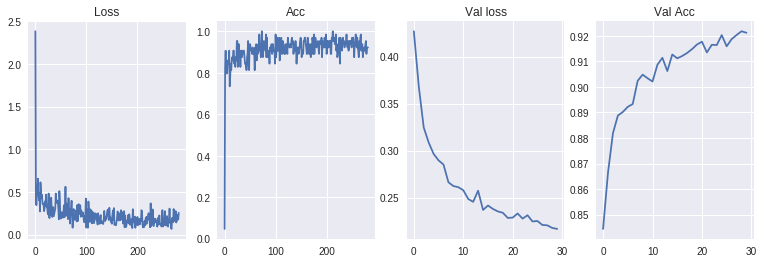

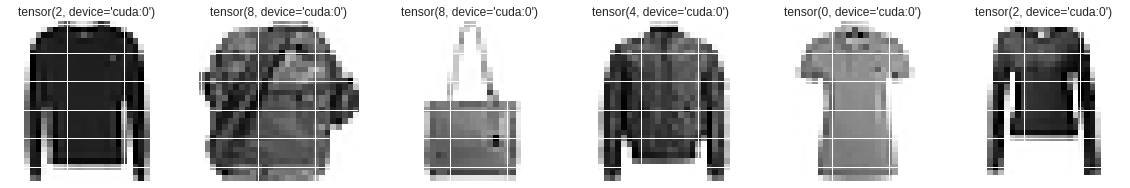

In [80]:
#Change Args Object Here
#Skip this step for P14 only
run_experiment(P13)


In [0]:
#Uncomment and run this only after problem 13 run
#P14_test_mnist(P14)